In [1]:
import sys
from scipy.constants import c,pi
import numpy as np
from math import factorial
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.constants import c

In [2]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 28}

matplotlib.rc('font', **font)

In [3]:
def betas_transf(lamda, lamda_c, betas):
    c_norm = c  # Speed of light [m/ps] 
    wc = 2*pi * c_norm / lamda
    w0 = 2*pi * c_norm / lamda_c
    betap = np.zeros_like(betas)
    for i in range(1):
        for j in range(len(betas.T)):
            if j ==0:
                betap[i,j] = betas[i,j]
            fac = 0
            for k in range(j, len(betas.T)):
                #print(j,k, factorial(fac), betas[i, k], (wc - w0)**(fac))
                betap[i, j] += factorial(fac)**(-1) * \
                    betas[i, k] * (wc - w0)**(fac)
                fac += 1
    return betap[0]


def domega(omegap,omega0,beta,gama, P0):
    omega = omegap - omega0
    a = beta[4]/12 #$+ omega * beta[5]/12
    b = beta[2]#+ omega*beta[3] +omega**2 * beta[4]/2 + omega**3 * beta[5]/6
    c = 2 * gama * P0
    
    det = b**2 - 4 * a * c
    if det >= 0:
        Omega = (-b + det**0.5)/(2*a)
        
        if Omega <0:
            Omega = (-b - det**0.5)/(2*a)
        if Omega <0:
            print("No real solution!")
            sys.exit("No real solution!")
        else:
            #print(Omega)
            return Omega**0.5
    else:
        print(' No real sollution in the det', det)
        sys.exit(' No real sollution in the det', det)

    return 1

def dlamda_sig(Omega,lamdap):
    return Omega * lamdap**2 / (2* pi* c - Omega * lamdap)*1e9

def dlamda_idl(Omega,lamdap):
    return Omega * lamdap**2 / (-2* pi* c - Omega * lamdap)*1e9

In [4]:

def plot(sols):
    N = 2**15
    lamdap_const = sols
    lamdaps = np.linspace(1046e-9,1054e-9,N)
    lamdaps = np.ndarray.tolist(lamdaps)
    lami = []
    lams = []
    for lamdap in lamdaps:
        betas = betas_transf(lamdap,lamda0,betas_or)
        Omega  = domega(2*pi *c /lamdap,2*pi *c /lamda0,betas,10*1e-3,15)
        dlamda_s = dlamda_sig(Omega,lamdap)
        dlamda_i = dlamda_idl(Omega,lamdap)
        lami.append(lamdap*1e9 + dlamda_i)
        lams.append(lamdap*1e9 + dlamda_s)
    lamdaps = [i*1e9 for i in lamdaps]

    loc = np.argsort(np.abs(np.asanyarray(lamdaps) - lamdap_const*1e9))[0] # location of the lamda0

    plt.plot(lamdaps,lami, label='idler')
    plt.plot(lamdaps,lams, label='signal')
    plt.plot((lamdap_const*1e9,lamdap_const*1e9),(900,1250), label='asked_for_wavelength')
    plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.ylabel('Parametric wavelength (nm)')
    plt.ylim([900,1250])
    #plt.legend(loc=1)
    plt.xlabel('Pump wavelength (nm)')
    print("The asked for pump wavelength ", lamdap_const*1e9,"nm results in hits of:",lami[loc] ,"nm idler and:",lams[loc],"nm signal.",)
    #plt.close()
    plt.show()
    return lamdap_const*1e9, lami[loc], lams[loc]


In [5]:
def find_dlami(lamp,lamisol, lamda0, betas):
    betas = betas_transf(lamp,lamda0,betas_or)
    Omega  = domega(2*pi *c /lamp,2*pi *c /lamda0,betas,10e-3,7)
    dlamda_i = dlamda_idl(Omega,lamp)
    dlamda_s = dlamda_sig(Omega,lamp)
    lami = lamp*1e9 + dlamda_i
    lams = lamp*1e9 + dlamda_s
    return lami - lamisol*1e9

In [6]:
beta0 = 0
beta1 = 0
beta2 = 0
beta3 = 6.756e-2 *(1e-12)**3*1e-3
beta4 = -1.002e-4 * (1e-12)**4*1e-3
beta5 = 3.671*1e-7*(1e-12)**5*1e-3
betas_or = np.array([[0, 0, 0, 6.756e-2*(1e-12)**3, -1.002e-4*(1e-12)**4, 3.671e-7*(1e-12)**5]])*1e-3
lamda_fast, lamda_slow = 1052.95e-9, 1051.85e-9
lamda0 =  lamda_slow

The asked for pump wavelength  1048.17107345 nm results in hits of: 929.62601089 nm idler and: 1201.36820373 nm signal.


/home/john/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


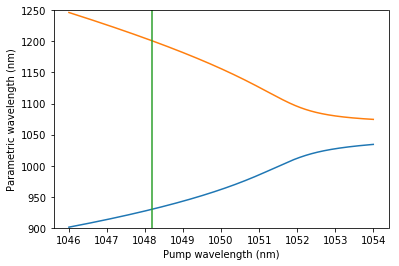

In [7]:
%matplotlib inline
pump_tot = []
lams_tot = ()
lami_search_vec = [931, 942,919.7,925.3,931.4,940.5,930,940]
lami_search_vec = [930]#1300
#lami_search_vec = [907.071587257, 914.682221613, 917.462384898, 926.920155732, 932.870539474, 944.603966761]
for i, lami_search in enumerate(lami_search_vec):
    sol = fsolve(find_dlami,1050e-9, args = (lami_search*1e-9,lamda0, betas_or))[0]
    pump_tot.append(sol)

    find_dlami(sol,931e-9, lamda0, betas_or)
    ccc = plot(pump_tot[i])[2]
    lams_tot += (ccc,)
#c = plot(sol)[2]
pump_tot = [i * 1e9 for i in pump_tot]

In [8]:
for i in range(len(lams_tot)):
    print(lams_tot[i], pump_tot[i], lami_search_vec[i])


1201.36820373 1048.17107345 930


In [9]:
import numpy as np
np.arange(0.5,5.5,0.5)

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])

In [10]:
lam_p_del = [1047.0, 1047.6, 1047.8, 1048.5, 1048.9, 1049.6]

# Finding L1, L2
The attenuation of the system in units of decibels is relates to the transmitence T as:

$$
\alpha_{tot} = -10 \log\left(T\right)
$$
.

Since the splices for PCF is considered to be high two different types of splice losses are assumed. The first $l_1$ is considered the splice loss for the PCF and the second $l_2$ descibes the rest of the losses within the system. 

The total loss in units of dB within our system is found to be:

$$
\alpha_{tot}\left(\lambda\right) = 2 l_{1} + k l_{2} + l_{fibre} - \sum^{N}_{i = 1}10 \log\left(WDM^{(i)}_{p^{(i)}}\left(\lambda\right)\right)
$$
, where $p{(i)}$ is the port that light light is to travel. 


Within the test case $1.4 dB$ loss was quoted within the cavity for a wavelength of $1205nm$ with $1dB$ being given to the loss of the fibre and the PCF losses. 

Since the fibre loss along the length of the fibre is quoted as $a_{L} \cdot L = 0.021dB$ the splice loss can be calculated as

$$
2 \cdot l_{1} + a_{L} \cdot L = 1 \Rightarrow l_{1} = \frac{1 -  a_{L} \cdot L}{2} =  \frac{1 -   0.021}{2} = 0.4895 dB.
$$

Within the cavity the signal is high at the wavelength of: 

Furthermore from this one can consider the second splice loss by taking the loss of the wdm 1, 2 for the signal as:
* port2 of WDM1
* port2 of WDM2

again as above but now with the ring (2 small splices) and the WDM losses with respect to the signal ports. 
The equation to be solved is then:
$$
T(1200) = WDM^{(1)}_{p2}\left(1200 \right) + WDM^{(2)}_{p2}\left(1200 \right) - 2 l_{1} - 3 l_{2} - l_{fibre}
$$


Hence the loss of the second splice can be found by:
$$
l_{2} =  \frac{T(1200) - WDM^{(1)}_{p2}\left(1200 \right) - WDM^{(2)}_{p2}\left(1200 \right) + 2 l_{1} + l_{fibre}}{3}
$$

In [11]:
def dB(x):
    if x< 1e-16:
        return 0
    return 10*np.log10(x)

In [12]:
def l2_f(lamda, T, l1):
    num = dB(1/T)  - 2 *l1 - 0.021 + dB(WDM1.il_port2(lamda)) +  dB(WDM2.il_port2(lamda))
    return num/3

In [13]:
def db(x):
    return 10*np.log10(x)

def wdm_losses(l):
    return db(WDM1.il_port2(l)) + db(WDM2.il_port2(l))# + db(WDM3.il_port1(l)) + db(WDM3.il_port1(l))
    

def total_loss(l, l1,l2):
    return  -2*l1 + -3*l2 + wdm_losses(l) - 0.021

def totalT(l,l1, l2):
    return 10**(total_loss(l,l1,l2)/10)

/home/john/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/john/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


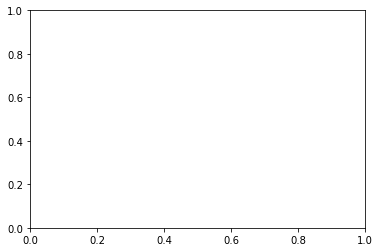

In [14]:
from functions import WDM
lv = np.linspace(800, 1500, 512)
fv = c/lv
WDM1 = WDM(1050, 1200,fv,c)
WDM2 = WDM(930, 1200, fv,c)
WDM3 = WDM(930, 1050,fv,c)
WDM4 = WDM(930, 1200,fv,c)
#WDM1 = WDM(1051.16, 1116.4,fv,c)
#WDM2 = WDM(989.1325877622734, 1116.4, fv,c)
#WDM3 = WDM(989.1325877622734, 1051.16,fv,c)
#WDM4 = WDM(989.1325877622734, 1116.4,fv,c)

In [15]:
l1 = 0.4895
l2 = l2_f(1200, 0.72, l1)
print('the splice loss of the small loss ones is:', l2, 'dB')

the splice loss of the small loss ones is: 0.142225011896 dB


In [16]:
l_p, l_s,l_i  =1048.17107345, 1201.36820373, 930

In [17]:
WDM1 = WDM(l_p, l_s,fv,c)
WDM2 = WDM(l_i, l_s, fv,c)
WDM3 = WDM(l_i, l_p,fv,c)
WDM4 = WDM(l_i, l_s,fv,c)

In [18]:
f_sig = 1e-3 * c/l_s
f_p = 1e-3 * c/l_p
f_c = f_sig - f_p +f_sig
f_i = f_p +f_p -f_sig

In [19]:
1e-3*c/f_i

929.6261819904777

/home/john/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


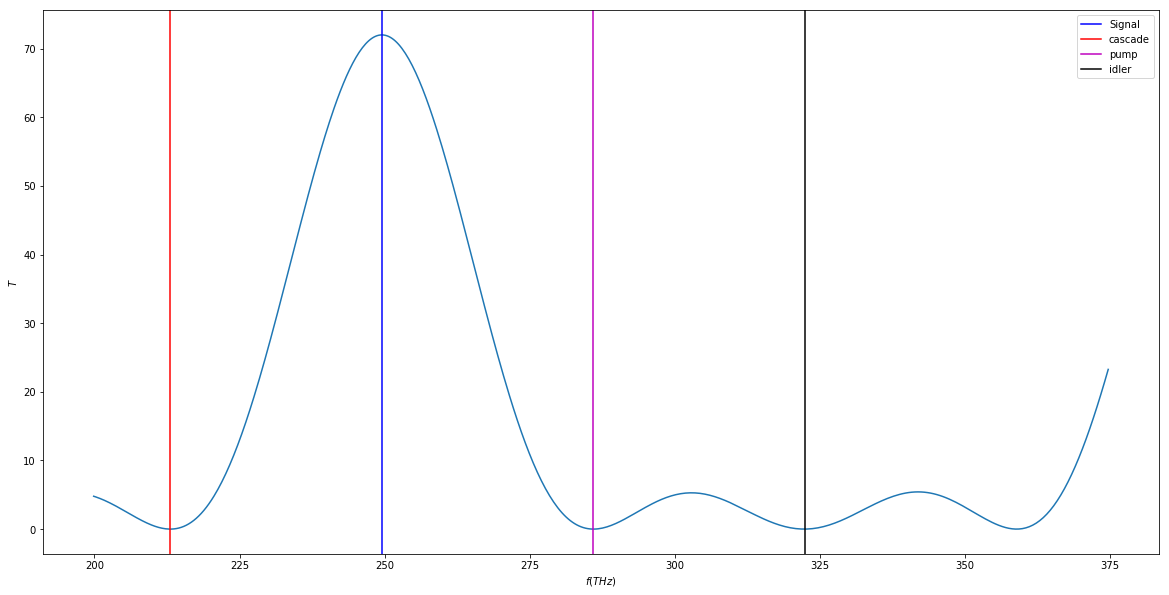

In [20]:
fig = plt.figure(figsize=(20.0, 10.0))
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(1e-3*c/lv, 100*totalT(lv,l1, l2))
plt.axvline(f_sig, label = 'Signal',color='b')
plt.axvline(f_c, label = 'cascade',color='r')
plt.axvline(f_p, label = 'pump',color='m')
plt.axvline(f_i, label = 'idler',color='k')
plt.xlabel(r'$f(THz)$')
#plt.xlim(1050, 1250)
#plt.ylim(0,80)
plt.legend()
plt.ylabel(r'$T$')
plt.savefig('stable.png')
#plt.title(['max at', np.max(100*totalT(lv,l1, l2))])
plt.show()

/home/john/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


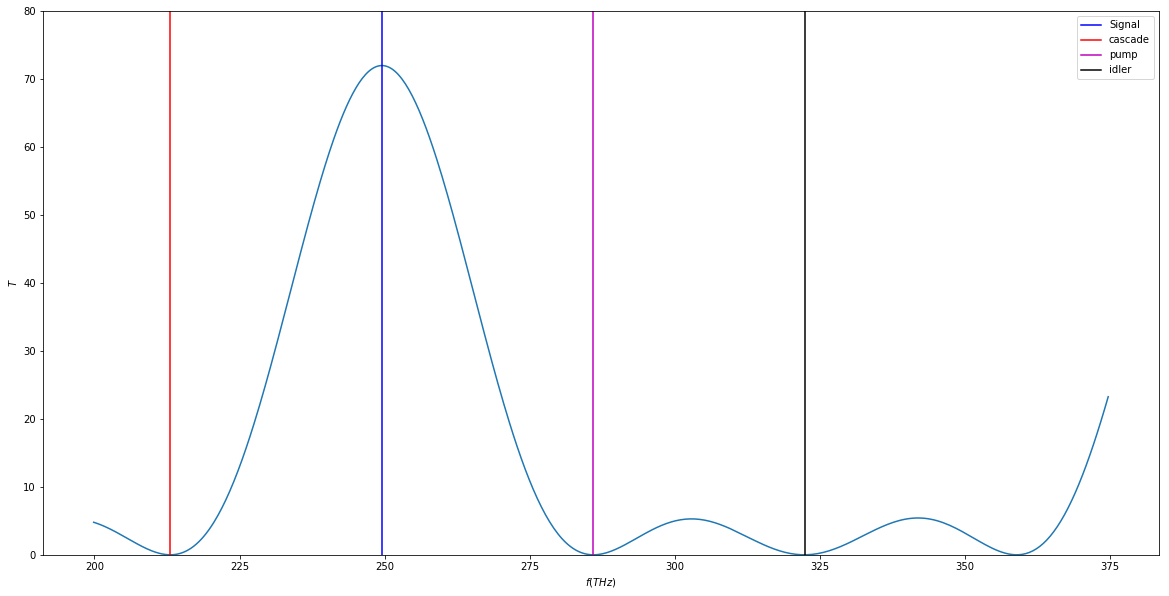

In [21]:
#%matplotlib inline
fig = plt.figure(figsize=(20.0, 10.0))
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(1e-3*c/lv, 100*totalT(lv,l1, l2))
plt.axvline(f_sig, label = 'Signal',color='b')
plt.axvline(f_c, label = 'cascade',color='r')
plt.axvline(f_p, label = 'pump',color='m')
plt.axvline(f_i, label = 'idler',color='k')
plt.xlabel(r'$f(THz)$')
#plt.xlim(1050, 1250)
plt.ylim(0,80)
plt.legend()
plt.ylabel(r'$T$')
plt.savefig('stable.png')
#plt.title(['max at', np.max(100*totalT(lv,l1, l2))])
plt.show()

In [22]:
totalT(1123.97515934,l1,l2)

0.34110397969328859

According to the theory from the FOPO book the theoretical threshold limit is found to be:

In [23]:
from math import acosh
import numpy as np
acosh = np.vectorize(acosh)
def P_th(T, g , L):
    a = (g*L)**(-1)
    b = acosh(np.sqrt(T)**(-1))
    return a*b


In [24]:
pth = P_th(totalT(lv,l1, l2),10e-3, 18)

In [25]:
P_th(totalT(1120,l1, l2),10e-3, 18)

6.6070158121873996

(0, 20)

/home/john/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


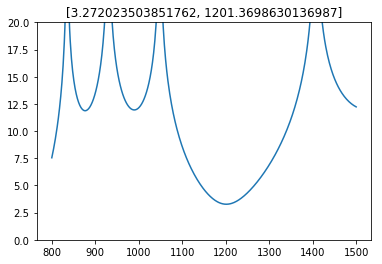

In [26]:
#%matplotlib inline
#fig = plt.figure(figsize=(20,10))
plt.plot(lv, pth)
plt.title([np.min(pth), lv[np.argmin(pth)]])
plt.ylim(0,20)

In [27]:
from fft_module import *

In [28]:
conda install mkl

SyntaxError: invalid syntax (<ipython-input-28-7dea755c2ab5>, line 1)

In [ ]:
fft,ifft,method = pick(100,2,1000,1)

In [ ]:
N_big = []
t_small = []
t = []
for n in range(1,17):
    N =  2**n
    A = np.random.rand(N) + 1j * np.random.rand(N) 
    for i in range(10000):
        t1 = time()
        A = ifft(A)
        dt = time() - t1
        t_small.append(dt)
    t.append(np.average(t_small))
    N_big.append(N)

In [ ]:
import matplotlib.pyplot as plt
#%matplotlib inline
plt.plot(np.log2(N_big), np.log(np.asanyarray(t)*1e6))
plt.xlabel('log2(Num of points)')
plt.ylabel('time (us)')
plt.title('Intel scipy')
#plt.savefig('intel_scipy.png')

In [ ]:
100*10**(-np.arange(0.5,5.5,1)[::-1]/10)